In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Augmented transformations for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10)      # Randomly rotate images by up to 10 degrees
])

validation_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=train_transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=validation_transform, download=True)

# Create data loaders datasets
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


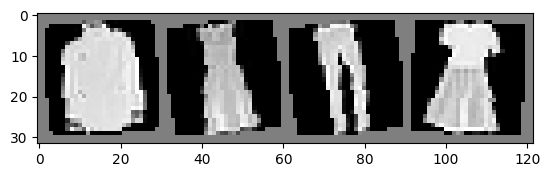

Coat | Dress | Trouser | Dress


In [5]:
# Plot training images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize for proper display
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()


dataiter = iter(training_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' | '.join(classes[labels[i]] for i in range(4)))

In [6]:
def plot_label_distribution_from_loader(dataloader, classes):
    label_counts = {name: 0 for name in classes}
    for _, labels in dataloader:
        labels = labels.numpy()
        for label in labels:
            classname = classes[label]
            label_counts[classname] +=1
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.xticks(rotation='vertical')
    plt.show()
    

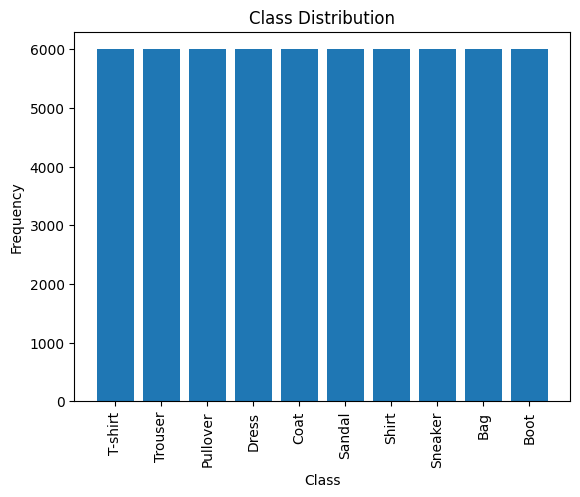

In [7]:
plot_label_distribution_from_loader(training_loader, classes)
# plot_label_distribution_from_loader(validation_loader, classes)

In [8]:
# Model
import torch.nn as nn
import torch.nn.functional as F

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
model = FashionCNN()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent


In [10]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter()

EPOCHS = 10
best_vloss = 1_000_000.  # Initialize the best validation loss


In [11]:
def train_one_epoch(model, data_loader, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in data_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Generate predictions
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Compute gradient
        optimizer.step()  # Update weights
        running_loss += loss.item()  # Sum up the loss

    avg_loss = running_loss / len(data_loader)  # Calculate average loss
    return avg_loss

In [12]:

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}:')

    # Train for one epoch
    avg_loss = train_one_epoch(model, training_loader, loss_fn, optimizer)
    
    # Validation phase
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for vinputs, vlabels in validation_loader:
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(validation_loader)  # Calculate average validation loss
    print(f'LOSS train {avg_loss:.3f} valid {avg_vloss:.3f}')

    # TensorBoard logging
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch + 1)
    writer.flush()

    # Model checkpointing
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch}.pth'
        torch.save(model.state_dict(), model_path)

    print(f"Model saved to {model_path}")

writer.close()

EPOCH 1:
LOSS train 0.719 valid 0.474
Model saved to model_20240322_163130_0.pth
EPOCH 2:
LOSS train 0.431 valid 0.391
Model saved to model_20240322_163130_1.pth
EPOCH 3:
LOSS train 0.375 valid 0.367
Model saved to model_20240322_163130_2.pth
EPOCH 4:
LOSS train 0.353 valid 0.347
Model saved to model_20240322_163130_3.pth
EPOCH 5:
LOSS train 0.335 valid 0.326
Model saved to model_20240322_163130_4.pth
EPOCH 6:
LOSS train 0.321 valid 0.337
Model saved to model_20240322_163130_4.pth
EPOCH 7:
LOSS train 0.312 valid 0.332
Model saved to model_20240322_163130_4.pth
EPOCH 8:
LOSS train 0.306 valid 0.320
Model saved to model_20240322_163130_7.pth
EPOCH 9:
LOSS train 0.296 valid 0.313
Model saved to model_20240322_163130_8.pth
EPOCH 10:
LOSS train 0.291 valid 0.310
Model saved to model_20240322_163130_9.pth


In [26]:
from PIL import Image
input_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


image_path = './data/sample/tshirt.png'
#image_path = './data/sample/sneaker.jpeg'
image = Image.open(image_path)
image = input_transform(image)
image = image.unsqueeze(0)  # Add a dummy batch dimension (B x C x H x W)

In [23]:
model.eval()
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]
print(f'item: {predicted.item()}')
print(f'Predicted class: {predicted_class}')

item: 8
Predicted class: Bag


In [24]:
# Example: Evaluating model accuracy on the validation set
correct, total = 0, 0
for images, labels in validation_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Validation Accuracy: %d %%' % (100 * correct / total))

Validation Accuracy: 88 %
